In [1]:
import pandas as pd
from collections import defaultdict
import seaborn as sns
from tqdm.notebook import trange, tqdm

In [2]:
appris = pd.read_csv('Data/appris_transcript_names.tsv', sep='\t', header=None, names=['gene','ref'])
nonappris = pd.read_csv('Data/not_appris_transcript_names.tsv', sep='\t', header=None, names=['gene','notref'])
def ref_nonref(gene):
    ref = appris.loc [ appris['gene']== gene]['ref'].tolist()
    #print (ref)
    non_ref = nonappris.loc [nonappris['gene']==gene]['notref'].tolist()
    non_ref.sort()
    #print (non_ref)
    return (ref, non_ref)

In [5]:
## Read in full blast results  - Using version 2
# Note version 1 of blast_full_PDB_vs_gencode had some lines that were Warnings
columns =  ['qseqid','qlen', 'qstart', 'qend', 'sseqid', 'slen', 'sstart', 'send', 'evalue', 'bitscore', 'length', 'nident', 'gaps','gapopen', 'mismatch', 'pident']
blast_df= pd.read_csv('Data/blast_full_PDB_vs_gencode_v2.tsv', sep='\t', header = 1, names = columns)
# Reduce the sseqid to just isoform name
blast_df['sseqid'] = [ s.split('|')[0] for s in blast_df['sseqid'].to_list()]
blast_df

,qseqid,qlen,qstart,qend,sseqid,slen,sstart,send,evalue,bitscore,length,nident,gaps,gapopen,mismatch,pident
1,7evw_R,599,36,574,FZD1-201,647,103,647,0.000000e+00,905.0,551,440,18,6,93,79.855
2,7evw_R,599,38,574,FZD2-201,565,28,565,0.000000e+00,893.0,553,434,31,3,88,78.481
3,7evw_R,599,49,563,FZD5-201,585,33,536,2.420000e-180,523.0,533,276,47,14,210,51.782
4,7evw_R,599,44,589,FZD10-201,581,29,573,1.480000e-165,485.0,562,261,33,10,268,46.441
5,7evw_R,599,49,562,FZD3-201,666,28,512,2.230000e-162,480.0,515,236,31,3,248,45.825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909511,"2z9a_A,B",88,3,81,PSAP-201,524,311,389,7.630000e-47,157.0,79,79,0,0,0,100.000
1909512,"2z9a_A,B",88,3,55,PSAP-204,167,115,167,4.070000e-31,108.0,53,53,0,0,0,100.000
1909513,8d58_A,246,1,246,METTL1-202,276,20,265,0.000000e+00,516.0,246,246,0,0,0,100.000
1909514,8d58_A,246,104,240,METTL1-204,124,2,124,3.650000e-85,250.0,137,123,14,1,0,89.781


### Next cell is slow. >2hr. 

Ways to speed it up:  
    - Create a ref_nonref dict, and only run the function if gene not in dict keys  
    - Make a column (ref-nonref), then group by that to get the max scores

In [76]:
pdb_scores = defaultdict(dict)
for q in tqdm(blast_df['qseqid'].unique()):
    #print (q)
    q_df = blast_df.loc[ blast_df['qseqid'] == q ].reset_index()
    max_bs = q_df['bitscore'].tolist()[0]
    pdb_scores[q]['top'] = max_bs
    
    gene = q_df['sseqid'].tolist()[0].split('-')[0]
    pdb_scores[q]['gene'] = gene
    ref, nonref = ref_nonref(gene)
    #print (ref,nonref)
    
    # Check if all top matches are nonref
    top_df = q_df.loc[ q_df['bitscore'] == max_bs ]
    top_df2 = top_df.copy()
    top_df2['non'] = top_df['sseqid'].isin(nonref)
    pdb_scores[q]['top_nonref'] = top_df2['non'].all()
        
    # Get top bitscore for non-appris
    non_df = q_df.loc [q_df['sseqid'].isin(nonref)]
    pdb_scores[q]['max_nonref_bs'] = non_df['bitscore'].max()
    # Get top bitscore for non-appris
    appris_df = q_df.loc [q_df['sseqid'].isin(ref)]
    pdb_scores[q]['max_ref_bs'] = appris_df['bitscore'].max()
    
pdb_scores_df = pd.DataFrame.from_dict(pdb_scores, orient='index')
pdb_scores_df 

,top,gene,top_nonref,max_nonref_bs,max_ref_bs
7evw_R,905.0,FZD1,False,NaN,905.0
2zb4_A,728.0,PTGR2,False,446.0,728.0
7tql_e,85.5,FAU,True,85.5,86.3
5wp1_A,744.0,MAPK1,False,632.0,744.0
"7e8h_I,K",1588.0,DPP6,True,1588.0,1587.0
...,...,...,...,...,...
"6l98_A,B",223.0,IGLL5,False,NaN,223.0
1adq_L,223.0,IGLL5,False,NaN,223.0
4z0x_A,180.0,IGLV3,False,NaN,NaN
"2z9a_A,B",157.0,PSAP,False,108.0,157.0


### Revised version max ref/non-ref calculation
This is faster than before, but still slow. Took 1.6 hrs

In [32]:
pdb_scores = defaultdict(dict)
ref_nonrefs = defaultdict(tuple)
for q in tqdm(blast_df['qseqid'].unique()):
    #print (q)
    q_df = blast_df.loc[ blast_df['qseqid'] == q, ['qseqid','sseqid','bitscore'] ].reset_index()
    max_bs = q_df['bitscore'].tolist()[0]
    pdb_scores[q]['top'] = max_bs
    
    gene = q_df['sseqid'].tolist()[0].split('-')[0]
    pdb_scores[q]['gene'] = gene
    if gene not in ref_nonrefs:
        ref, nonref = ref_nonref(gene)
        ref_nonrefs[gene]=(ref,nonref)
    ref,nonref = ref_nonrefs[gene]
    #print (gene,ref,nonref)
    
    # Check if all top matches are nonref
    top_df = q_df.loc[ q_df['bitscore'] == max_bs ]
    top_df2 = top_df.copy()
    top_df2['non'] = top_df['sseqid'].isin(nonref)
    pdb_scores[q]['top_nonref'] = top_df2['non'].all()
        
    # Get top bitscore for non-appris
    q_df['ref_nonref'] = q_df['sseqid'].isin(nonref)
    #print (q_df)
    q_df_g = q_df.groupby('ref_nonref', as_index = False)['bitscore'].max()
    #print (q_df_g)        
    non_ref_score = q_df_g.loc[ q_df_g['ref_nonref'] == True]['bitscore'].to_list()
    if non_ref_score:
        pdb_scores[q]['max_nonref_bs'] = non_ref_score[0]
    else:
         pdb_scores[q]['max_nonref_bs'] = 0
    ref_score =  q_df_g.loc[ q_df_g['ref_nonref'] == False]['bitscore'].to_list()
    if ref_score:
        pdb_scores[q]['max_ref_bs']  = ref_score[0]
    else:
        pdb_scores[q]['max_ref_bs']  = 0
    #print(pdb_scores[q])

    
pdb_scores_df = pd.DataFrame.from_dict(pdb_scores, orient='index')
pdb_scores_df 

,top,gene,top_nonref,max_nonref_bs,max_ref_bs
7evw_R,905.0,FZD1,False,0.0,905.0
2zb4_A,728.0,PTGR2,False,446.0,728.0
7tql_e,85.5,FAU,True,85.5,86.3
5wp1_A,744.0,MAPK1,False,632.0,744.0
"7e8h_I,K",1588.0,DPP6,True,1588.0,1587.0
...,...,...,...,...,...
"6l98_A,B",223.0,IGLL5,False,0.0,223.0
1adq_L,223.0,IGLL5,False,0.0,223.0
4z0x_A,180.0,IGLV3,False,0.0,180.0
"2z9a_A,B",157.0,PSAP,False,108.0,157.0


In [79]:
ps2 = pdb_scores_df.fillna(value=0)

Text(0.5, 1.1, 'Ref / Non-ref Bitscore Comparison')

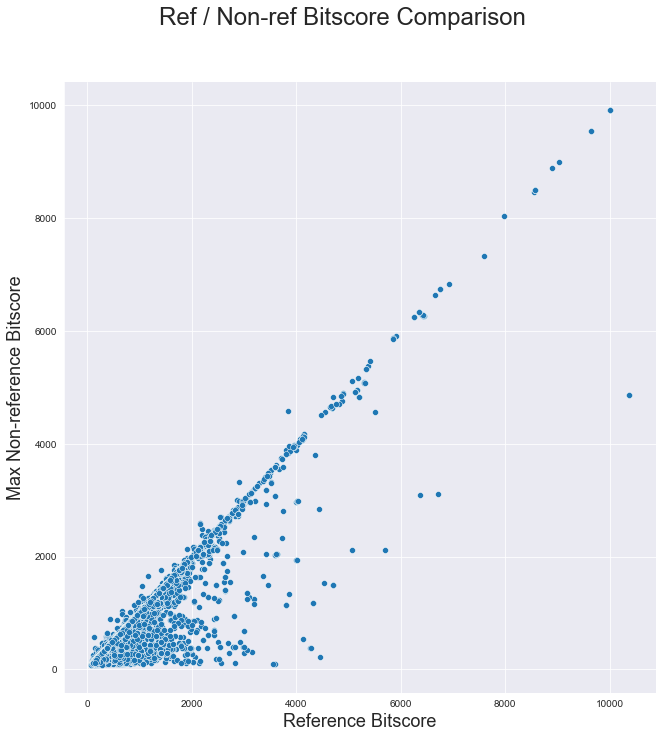

In [85]:
sns.set_style("darkgrid", {'axes.axisbelow': True})
g = sns.relplot(data=pdb_scores_df, x="max_ref_bs", y="max_nonref_bs", height=9)
#g.ax.axline(xy1=(10, 2), slope=.2, color="b", dashes=(5, 2))
g.set_axis_labels("Reference Bitscore", "Max Non-reference Bitscore", fontsize=18)
g.fig.suptitle("Ref / Non-ref Bitscore Comparison",
                  fontsize=24, fontdict={"weight": "bold"}, y=1.1)

# Set after plotting

### Group by gene. 

In [ ]:
pdb_scores_df.group_by

## Below here extra

### Next cell is slow. >2hr.  re-written above

Ways to speed it up:  
    - Create a ref_nonref dict, and only run the function if gene not in dict keys  
    - Make a column (ref-nonref), then group by that to get the max scores

In [76]:
pdb_scores = defaultdict(dict)
for q in tqdm(blast_df['qseqid'].unique()):
    #print (q)
    q_df = blast_df.loc[ blast_df['qseqid'] == q ].reset_index()
    max_bs = q_df['bitscore'].tolist()[0]
    pdb_scores[q]['top'] = max_bs
    
    gene = q_df['sseqid'].tolist()[0].split('-')[0]
    pdb_scores[q]['gene'] = gene
    ref, nonref = ref_nonref(gene)
    #print (ref,nonref)
    
    # Check if all top matches are nonref
    top_df = q_df.loc[ q_df['bitscore'] == max_bs ]
    top_df2 = top_df.copy()
    top_df2['non'] = top_df['sseqid'].isin(nonref)
    pdb_scores[q]['top_nonref'] = top_df2['non'].all()
        
    # Get top bitscore for non-appris
    non_df = q_df.loc [q_df['sseqid'].isin(nonref)]
    pdb_scores[q]['max_nonref_bs'] = non_df['bitscore'].max()
    # Get top bitscore for non-appris
    appris_df = q_df.loc [q_df['sseqid'].isin(ref)]
    pdb_scores[q]['max_ref_bs'] = appris_df['bitscore'].max()
    
pdb_scores_df = pd.DataFrame.from_dict(pdb_scores, orient='index')
pdb_scores_df 

,top,gene,top_nonref,max_nonref_bs,max_ref_bs
7evw_R,905.0,FZD1,False,NaN,905.0
2zb4_A,728.0,PTGR2,False,446.0,728.0
7tql_e,85.5,FAU,True,85.5,86.3
5wp1_A,744.0,MAPK1,False,632.0,744.0
"7e8h_I,K",1588.0,DPP6,True,1588.0,1587.0
...,...,...,...,...,...
"6l98_A,B",223.0,IGLL5,False,NaN,223.0
1adq_L,223.0,IGLL5,False,NaN,223.0
4z0x_A,180.0,IGLV3,False,NaN,NaN
"2z9a_A,B",157.0,PSAP,False,108.0,157.0


Text(0.5, 1.1, 'Ref / Non-ref Bitscore Comparison')

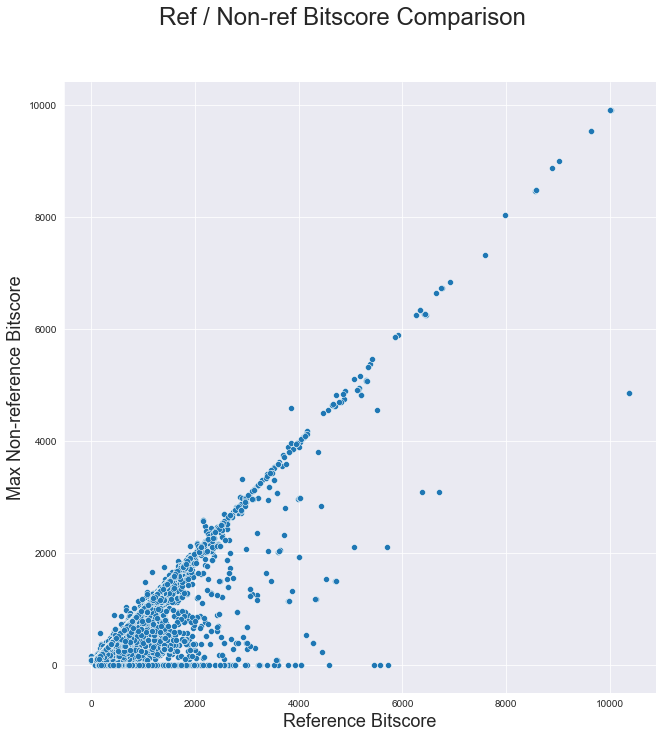

In [33]:
sns.set_style("darkgrid", {'axes.axisbelow': True})
g = sns.relplot(data=pdb_scores_df, x="max_ref_bs", y="max_nonref_bs", height=9)
#g.ax.axline(xy1=(10, 2), slope=.2, color="b", dashes=(5, 2))
g.set_axis_labels("Reference Bitscore", "Max Non-reference Bitscore", fontsize=18)
g.fig.suptitle("Ref / Non-ref Bitscore Comparison",
                  fontsize=24, fontdict={"weight": "bold"}, y=1.1)

# Set after plotting

In [48]:
### Write our resulting dataframe
ps_df.to_csv('Data/max_ref_nonref_bitscores.tsv', sep = '\t')

In [41]:
# Add a difference column to pdb_scores-df
ps_df = pdb_scores_df.copy()
ps_df['diff'] = pdb_scores_df['max_nonref_bs'] - pdb_scores_df['max_ref_bs']
ps_df = ps_df.sort_values(by=['diff'], ascending =False)
ps_df

,top,gene,top_nonref,max_nonref_bs,max_ref_bs,diff
6lth_L,4586.0,ARID1A,True,4586.0,3852.0,734.0
7ktr_C,1658.0,SUPT20H,True,1658.0,1163.0,495.0
"4kkd_A,B",892.0,MASP1,True,892.0,433.0,459.0
"7k36_B,D,E,F,G",1479.0,STRN3,True,1479.0,1046.0,433.0
8fgw_B,2585.0,IFT122,True,2585.0,2155.0,430.0
...,...,...,...,...,...,...
"7t3p_A,B,C,D",5445.0,ITPR3,False,0.0,5445.0,-5445.0
"7u9x_A,B,C,D",10359.0,RYR2,False,4861.0,10359.0,-5498.0
"7u9q_A,D,B,C",10362.0,RYR2,False,4861.0,10362.0,-5501.0
"6dqj_A,B,C,D",5566.0,ITPR3,False,0.0,5566.0,-5566.0
